# Calculating Timing Test Results

Okay, so we've run a timing test, where we presented an auditory stimulus while marking the event times using a TTL trigger. We recorded the true stimulus and the TTL pulse on the same amplifier, and saved it to an EEG file. Now, we want to load this data and compute the trial-by-trial offset between the trigger and the actual sound. The mean offset can be corrected for, so long as we measure it, but jitter (the standard deviation of the offset) is tougher to deal with.

Often, you'll have a second trigger recording the ground-truth event time instead of a literal recording of the stimulus audio, like we have here. (For example, if you used a hardware sound-level trigger to send a TTL pulse to your amp; a lot of EEG manufacturers will provide such hardware as their recommended solution.) In that case, you can simply subtract their timestamps to get the trial-by-trial offset between them.

To run this tutorial, you'll need to `pip install mne` if you haven't already. 

In [19]:
import numpy as np
import mne

The [MNE package](https://mne.tools/stable/index.html) provides a function for reading in Brain Vision files. If you just put in the `.vhdr` filename, it knows to load all three of the triplet files.

In [20]:
raw = mne.io.read_raw_brainvision('lettytest1.vhdr')

Extracting parameters from lettytest1.vhdr...
Setting channel info structure...


The TTL pulses we sent to the EEG amp have been recorded with timestamps in the `.vmrk` file (marker file). MNE loads these as "annotations," since the `.vmrk` files allow for more expressive event descriptions than MNE knows how to deal with.

Sometimes, instead of annotations, you'll have an extra data channel (at the same sampling rate as the EEG) that records the literal voltage on the the TTL channel or your event codes cast to floating point values. In that case, you can use MNE's `find_events` function to extract event times as in [this tutorial](https://mne.tools/dev/auto_tutorials/intro/20_events_from_raw.html).

In [21]:
raw.annotations

<Annotations | 1001 segments: New Segment/ (1), Stimulus/S100 (1000)>

There are 186 annotations for 186 events. The first event is just to mark the start of the recording, and the next 185 are our TTL pulses. (There were actually 200 trials in the timing test, but you may remember I didn't click record until part way through.)

Lets see what information an annotation contains.

In [22]:
raw.annotations[10] # the 11th event, or 10th TTL pulse, since Python is zero indexed

OrderedDict([('onset', 10.97944),
             ('duration', 4e-05),
             ('description', 'Stimulus/S100'),
             ('orig_time',
              datetime.datetime(2022, 1, 31, 17, 18, 40, 171000, tzinfo=datetime.timezone.utc))])

It literally records the date and time of the event, which isn't that helpful to us. (Tools like [MNE-BIDS](https://mne.tools/mne-bids/stable/index.html) will remove this type of information when organizing and anonymizing your dataset into BIDS format to share, but it is present in the fresh-off-the-presses files like this one.) We don't care about absolute time but rather about time since the start of the recording so we know what samples this corresponds to. We can get that manually by subtracting the first timestamp, or we can let MNE do the tedious part and make event codes for us in the format it likes to use.

In [23]:
events, event_ids = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S100']


The `events` object is just an array containing three columns: the first column contains the index of the sample in which the event starts, and the last column contains an integer event code. (The middle column is almost never used; it records the event reported on the immediately previous sample, but rarely are stimuli presented that close together.) 

In [24]:
events[:5, :] # first five events

array([[     0,      0,  99999],
       [222807,      0,    100],
       [228868,      0,    100],
       [235686,      0,    100],
       [240706,      0,    100]])

If the annotations contained numerical event codes, MNE will use the same codes in the third column. If the annotations were strings, it will assign event codes ordinally. `event_ids` is a dictionary that contains mappings from your original event annoations to the MNE-assigned event codes.

In [25]:
event_ids

{'New Segment/': 99999, 'Stimulus/S100': 100}

So you can select an event like so:

In [26]:
ttl_idx = (events[:,2] == event_ids['Stimulus/S100']) # true if event code matches selection
ttl_pulses = events[ttl_idx, :] # choose just events for which ttl_idx is true
ttl_pulses[:5, :] # leaves only the events I want!

array([[222807,      0,    100],
       [228868,      0,    100],
       [235686,      0,    100],
       [240706,      0,    100],
       [246478,      0,    100]])

All of our TTL events, in this case, were marked as `'Stimulus/S 16'` since this was a timing test and we only presented one stimulus. In a full experiment, we'd obviously have different event codes for different categories of stimuli.

Anyway, MNE can use this event array to break the recording up into epochs around events of interest. We'll take the 200 ms (or 0.2 seconds) before the stimulus and the 200 ms after, in case the TTL pulse ended up coming late, and we'll subtract out the average of the 100 ms before our candidate interval (so from -200 to -100 ms) to account for any baseline drift in the recording and center our data around zero.

In [48]:
epochs = mne.Epochs(raw, ttl_pulses, tmin = -.05, tmax = .2, baseline = (-.05, 0.))

Not setting metadata
Not setting metadata
1000 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


MNE's `Epochs` object has some handy methods for plotting the trial-by-trial data. 

Loading data for 1000 events and 6251 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-49-230fa890b6f4>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epochs.plot_image(picks = 'Aux1')


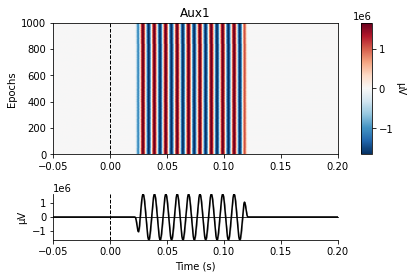

In [49]:
fig = epochs.plot_image(picks = 'Aux1')

MNE thinks we're plotting EEG data so the units are ridiculous, and it complains about not knowing channel locations. In the top plot, each row is a seperate trial and the color is amplitude, and the bottom plot is the average of all trials.

There appears to be some sort of periodicity in the stimulus offset. That could be something to investigate if we want to improve our jitter, since it suggests something is systematically affecting our timing. (In this case, it's probably not the presentation code but something else I had up on my computer. This is why you don't present stimuli with your personal laptop.) Also, __note that this sort of periodicity in stimulus latency can be dangerous if trials are not presented in a totoally random order (e.g. in a block design), since it could result in different average offsets per condition.__ In our case, the oddball trials and normal trials are presented in random order, so it doesn't matter. But that won't always be the case, so you should always check.

MNE's `Raw` and `Epochs` data types will, at any point, give you your data as an array. This is helpful when we want to do something MNE doesn't already have implemented, like we are right now.

In [50]:
data = epochs.get_data(picks = 'Aux1') # just the audio channel
data.shape

Loading data for 1000 events and 6251 original time points ...


(1000, 1, 6251)

Usually, when we're working in MNE, we'd have more than one channel of data, which is why we have that useless middle dimension of size one in our array. Let's squeeze our array to remove it.

In [51]:
data = np.squeeze(data)
data.shape

(1000, 6251)

Cool, now we have one row per trial. Now we just need to find where the audio first crosses an arbitrary threshold on each trial, and compare it to the time of our TTL trigger. Since we don't really care about the absolute voltage recorded by the amp, I'll just set the threshold at the 95% quantile of the baseline corrected recording.

In [52]:
thres = np.quantile(data, .95)
thres # sound cards make smol voltages

1.4845244552702856

In [53]:
latencies = [] # sound onset time - time of TTL trigger
above_thres = (data > thres) # true where data is above threshold
for trial in range(data.shape[0]):
    idx = np.argwhere(above_thres[trial, :])[0] # first index where crosses threshold
    delta = idx/epochs.info['sfreq'] + epochs.tmin # convert to time relative to trigger
    latencies.append(delta)
    
offset = np.mean(latencies)
offset * 1e3 # in milliseconds

28.244639999999997

So the computer gets around to playing the sound, on average, just shy of 5 milliseconds after we send our TTL trigger.

In [54]:
jitter = np.std(latencies)
jitter * 1e3 # in milliseconds

0.6319475218718719

The jitter isn't _amazing_, but it's good enough for most event-related potentials. For reference, when we're presenting auditory stimuli using PsychToolbox in Matlab, we normally get jitters of 3-ish milliseconds when we send software triggers over a local network and 0.3-ish milliseconds when we send hardware triggers like we did this time. The latter precision is only necessary if you're analyzing very high frequencies; the effect of jitter on the grand average ERP is essentially a low pass (or high cutoff) filter, since it is effectively averaging across neighboring time points. The most commonly analyzed ERP components are well below 50 Hz, so this much jitter is usually quite fine (as long as it's consistent across conditions), but not so fine if you're interested in, say, a [frequency-following response](https://en.wikipedia.org/wiki/Frequency_following_response). 

We used the [PsychToolbox](http://psychtoolbox.org) audio backend for [Psychopy](https://www.psychopy.org/api/sound.html), which is ostensibly calling the same code as we'd use in Matlab, so I'm thinking the added jitter is coming from the additional overhead of the Python interpreter. I've gotten really superb audio timing with the [pyo package](http://ajaxsoundstudio.com/software/pyo/) in Python, which wraps some really performant C code and is available as a Psychopy backend, so it may be possible to do better without entering the Matlab dumpster fire. Your operating system and sound hardware also matter a great deal, so the performance of any given stimulus presentation script will vary from machine to machine. Generally MacOS is better than Windows for sound, and a (low-latency) Linux kernal is better for all stimulus modalities if you know what you're doing. Having a professional sound card lowers latency but doesn't always improve jitter. 

The experiment script we used for this test is a decent example for how to present auditory stimuli. For visual stimuli, you will also need to account for the refresh rate of the screen when you're sending triggers, since most machines won't let you override the ongoing refresh rate. Psychopy and PsychToolbox should both have tutorials for how to do this properly. For somatosensory or muscle stimulation, you can often control the stimuluation apparatus using a TTL pulse, so your timing can be pretty much perfect if you use the same TTL pulse to both initiate and mark stimulation.

If you're collecting ERPs to stimuli in another modality, you are substantially cooler than me.

A final note is that you can also record the stimulus, as we did here, during the experiment (e.g. use a y-splitter or passthrough device for your audio). In that case, however, _do not_ use a level threshold as we did here to mark stimulus onset, since different sounds may cross threshold at different points in your stimulus file, and your arbitrary threshold may not be psychologically/perceptually meaningful. Instead, you would cross-correlate the stimulus file with the recorded audio to find the point of maximum overlap. Of course, this works less well for modalities that can't be easily digitized in the same format as your electrode voltages; good luck recording video on your EEG amp's clock. 